In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

plt.rcParams['font.size']=14

In [78]:
class packet():
    
    __morse_table = {'A':'.-', 'B':'-...', 'C':'-.-.', 'D':'-..', 'E':'.', 'F':'..-.', 'G':'--.', 'H':'....', 'I':'..', 'J':'.---', 'K':'-.-', 
                     'L':'.-..', 'M':'--', 'N':'-.', 'O':'---', 'P':'.--.', 'Q':'--.-', 'R':'.-.', 'S':'...', 'T':'-', 'U':'..-', 'V':'...-', 
                     'W':'.--', 'X':'-..-', 'Y':'-.--', 'Z':'--..', '1':'.----', '2':'..---', '3':'...--', '4':'....-', '5':'.....', 
                     '6':'-....', '7':'--...', '8':'---..', '9':'----.', '0':'-----', '!':'-.-.--', '"':'.-..-.', '&':'.-...', "'":'.----.', 
                     '(':'-.--.', ')':'-.--.-', '+':'.-.-.', ',':'--..--', '-':'-....-', '.':'.-.-.-', '/':'-..-.', ':':'---...', ';':'-.-.-', 
                     '=':'-...-', '?':'..--..', '@':'.--.-.', 'Ä':'.-.-', 'Å':'.--.-', 'Á':'.--.-', 'É':'..-..', 'Ö':'---.', 'Ü':'..--', 
                     'Ñ':'--.--', ' ':''}
    
    def __init__(self,mode=None):
        self._head = ''
        self._message = ''
        self._call = ''
        self._tone = 1200
        self.waveform = np.array([])
        self._samplerate = 48000
        self._mode = None
        self.encode = None
        self._valid_modes = ['morse',]
        if mode:
            self.set_mode(mode)
        
    def set_head(self,head):
        self._head = head
        
    def set_message(self,message):
        self._message = message
    
    def set_call(self,call):
        self._call = call
        
    def set_tone(self,tone):
        self._tone = tone
    
    def set_samplerate(self,fs):
        self._samplerate = fs
    
    def set_mode(self,mode):
        if mode not in self._valid_modes:
            print("Provided mode not valid. Please use one of these modes:")
            print("\t",self._valid_modes)
        else:
            self._mode = mode
            self.encode = self._encode_morse
    
    def _mark(self,length,fadewidth=2,time=False):
        t = np.arange(0,length,1/self._samplerate)
        y = np.sin(2*np.pi*self._tone*t)
        ramp = np.ones_like(t)
    
        n = int(self._samplerate*(fadewidth/1000))
        fade = (1-(np.cos(np.linspace(0,np.pi,n))))/2
        ramp[:n] *= fade
        ramp[-1*n:] *= fade[::-1]

        if time:
            return t,y*ramp
        else:
            return y*ramp
    
    def _space(self,length,time=False):
        t = np.arange(0,length,1/self._samplerate)
        y = 0*t
        if time:
            return t,y
        else:
            return y
    
    def _encode_morse(self, char_rate, word_rate=None, padding='none', padsize=0.5, fadewidth=2, use_call=False):
        
        frontpad,endpad = ({'front':(True,False), 'back':(False,True), 'both':(True,True)}).get(padding,(False,False))
        
        if self._mode != 'morse':
            print("Mode Error: Packet mode must be set to morse for this encoding method.")
            return
        
        print("Encoding message in morse code audio at {0} Hz".format(self._tone))

        if word_rate is None:
            word_rate = char_rate
        if char_rate < word_rate:
            print("Encoding Error: Character speed must be at least the effective word speed.")
            return
        
        if np.array([c.upper() not in self.__morse_table.keys() for c in self._head]).any():
            print("Encoding Error: Head contains unsupported characters.")
            return
        
        if np.array([c.upper() not in self.__morse_table.keys() for c in self._message]).any():
            print("Encoding Error: Message contains unsupported chracters.")
            return
        
        char_bittime = 1.2/char_rate
        timing = {'.':1*char_bittime, '-':3*char_bittime}
        signal = np.array([])
        
        if frontpad:    # Pad the front with some extra time. 
            signal = np.concatenate([signal,self._space(padsize)])
        
        full_message = ''
        if use_call:
            full_message = 'de ' + self._call + '  '
        if self._head != '':
            full_message += self._head + '  ' + self._message
        else:
            full_message += self._message
            
        farns = (60-31*word_rate*char_bittime)/(19*word_rate)    
        prior = False
        
        for c in full_message:

            if c == ' ':
                if prior:
                    signal = np.concatenate([signal,self._space(3*farns)])
                signal = np.concatenate([signal,self._space(4*farns)])
                prior = True
            else:
                for e in self.__morse_table[c.upper()]:
                    signal = np.concatenate([signal,self._mark(timing[e],fadewidth=fadewidth)])
                    signal = np.concatenate([signal,self._space(char_bittime)])
                signal = np.concatenate([signal,self._space(3*farns-char_bittime)])
                prior = False

        back = self._space(3*farns)    # Remove the last extraneous 3(2) farnsworth(bit) times
        signal = signal[:-1*len(back)]
    
        if endpad:
            signal = np.concatenate([signal,self._space(padsize)])
        
        print("Success! Waveform has been encoded.")
        self.waveform = signal
        return

In [79]:
morse = packet(mode='morse')
morse.set_message("This is a test.")
morse.set_call('k7arx')


In [80]:
morse._message

'This is a test.'

In [81]:
morse._call

'k7arx'

In [82]:
morse._head

''

In [83]:
morse.waveform

array([], dtype=float64)

In [84]:
morse._mode,morse.encode

('morse',
 <bound method packet._encode_morse of <__main__.packet object at 0x7f0245835a60>>)

In [85]:
morse.set_mode('blah')

Provided mode not valid. Please use one of these modes:
	 ['morse']


In [86]:
morse.set_mode('morse')

In [87]:
morse.set_tone(700)

In [96]:
morse.encode(15, use_call=True, padding='both')

Encoding message in morse code audio at 700 Hz
Success! Waveform has been encoded.


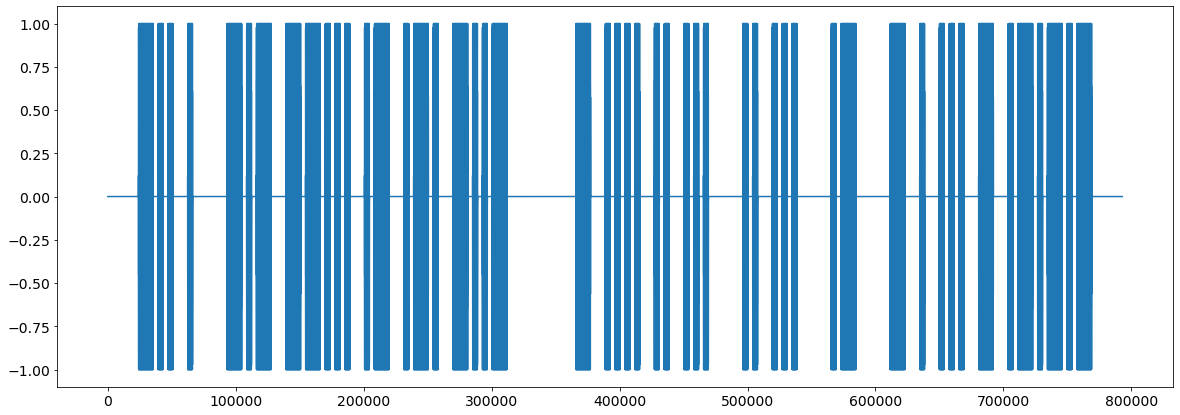

In [97]:
old_waveform = morse.waveform.copy()
plt.figure(figsize=(20,7))
plt.plot(morse.waveform)

Encoding message in morse code audio at 700 Hz
Success! Waveform has been encoded.


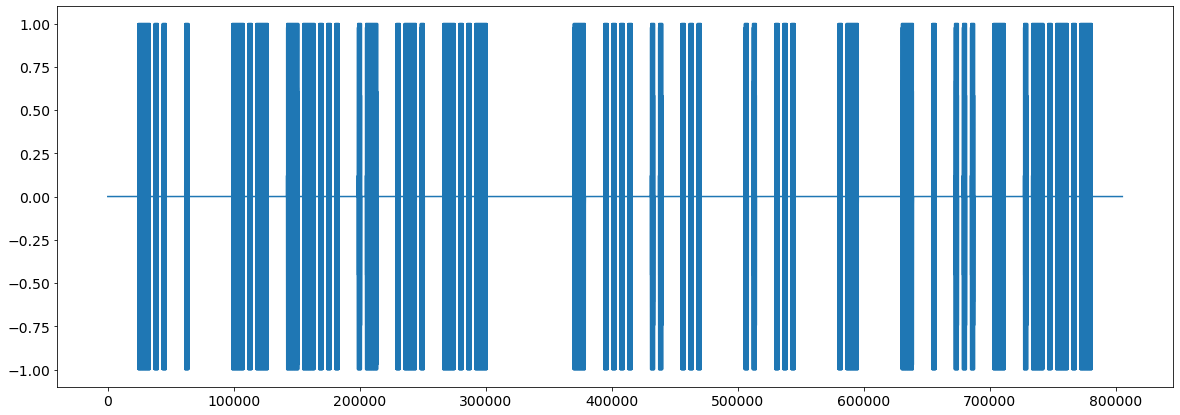

In [73]:
morse.encode(18,word_rate=15,use_call=True,padding='both')
plt.figure(figsize=(20,7))
plt.plot(morse.waveform)

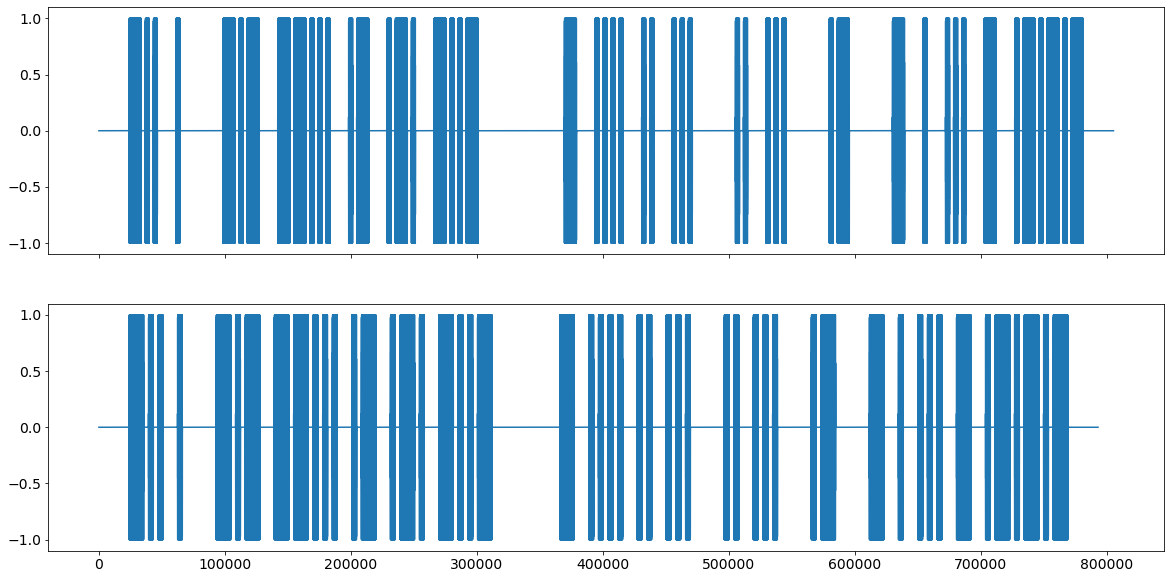

In [74]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(20,10))
ax[0].plot(morse.waveform)
ax[1].plot(old_waveform)
#for a in ax:
 #   a.set_xlim(0,120000)

Encoding message in morse code audio at 700 Hz
Success! Waveform has been encoded.
Encoding message in morse code audio at 700 Hz
Success! Waveform has been encoded.


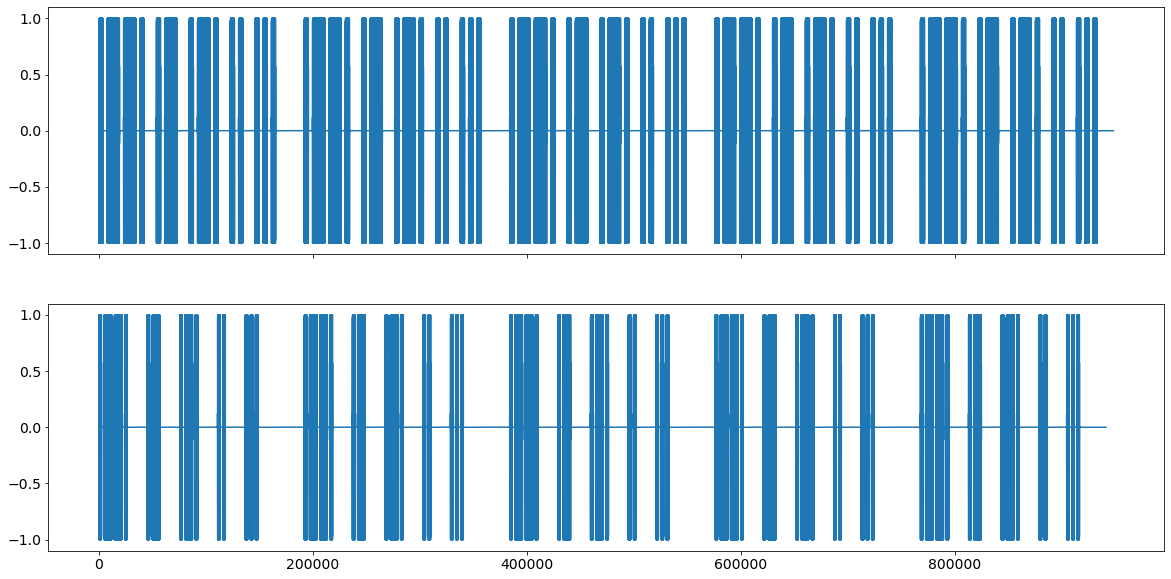

In [77]:
morse.set_message('paris paris paris paris paris ')
morse.encode(15)
strict = morse.waveform.copy()
morse.encode(24,word_rate=15)

fig,ax = plt.subplots(2,1,sharex=True,figsize=(20,10))
ax[0].plot(strict)
ax[1].plot(morse.waveform)